In [61]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from astropy.constants import G, c, M_sun, hbar

import astropy.units as u
from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

In [62]:

hc = 197.3269804  # MeV fm
B_1 = 145 ** 4 # Mev^4 

B_2 = 200 ** 4 # MeV^4

n0 = 0.16 # fm^-3

n0_mev3 = 0.16 * (hc**3) # Convert 0.16 fm^-3 to MeV^3 
# Plank's mass

m_planck = np.sqrt((hbar * c) / G) # kg


M_p = (m_planck * c**2).to(u.MeV)

print(f"Planck Mass: {M_p:.4e}")


Planck Mass: 1.2209e+22 MeV


Adimensional 

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$

# Compute numerical values for the EoS

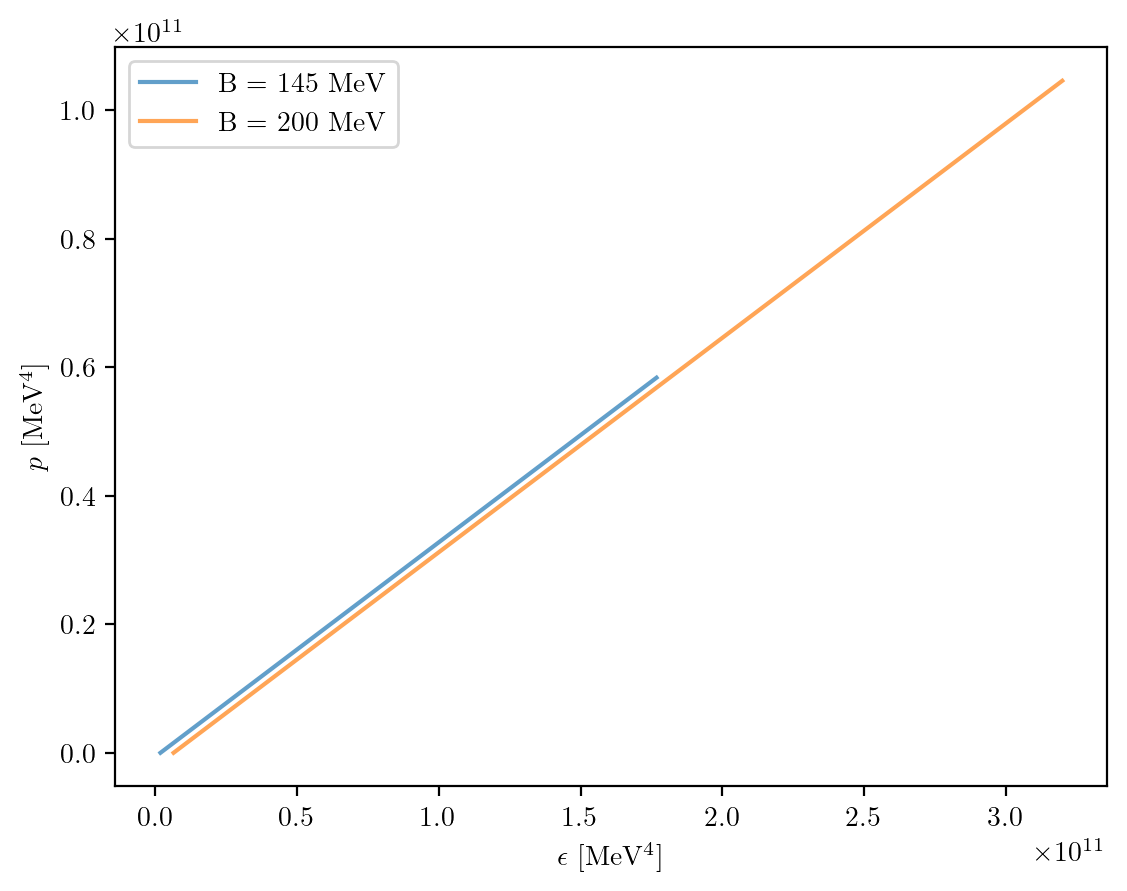

In [63]:
list_e_1 = np.linspace(1+1e-5, 100, 2000) * 4 * B_1
list_e_2 = np.linspace(1+1e-10, 50, 2000) * 4 * B_2

p_1 = 1/3*(list_e_1 - 4*B_1)
p_2 = 1/3*(list_e_2 - 4*B_2)

plt.plot(list_e_1, p_1, label='B = 145 MeV', alpha=0.7)
plt.plot(list_e_2, p_2, label='B = 200 MeV', alpha=0.7)
    
plt.xlabel(r'$\epsilon$ [MeV$^4$]')
plt.ylabel(r'$p$ [MeV$^4$]')
plt.legend()
plt.show()

The EoS is working

TOV:

$$
\frac{dp}{dr} = - \frac{M \epsilon}{r^2} \left(1+\frac{p}{\epsilon}\right) \left(1+ \frac{4\pi r^3 p}{M}\right)\left(1-\frac{2M}{r}\right)^{-1}
$$

$$
\frac{dM}{dr} = 4 \pi r^2 \epsilon
$$

Already wihout dimensions

In [64]:
list_p_1_adim = p_1 / (4 * B_1)
list_e_1_adim = list_e_1 / (4 * B_1)

list_p_2_adim = p_2 / (4 * B_2)
list_e_2_adim = list_e_2 / (4 * B_2)


In [65]:

def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_1_adim, list_e_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_1), 'MeV^4')

    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_1 = []
list_M_1 = []





for i in range(len(list_e_1_adim)):

    e, p = list_e_1_adim[i], list_p_1_adim[i]

    r0 = 1e-5

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_1.append(R_surface)
    list_M_1.append(M_surface)




Now for the second constant

In [66]:

def solve_TOV(central_energy, x0):
    def ode_TOV_2(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_2_adim, list_e_2_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_2,
        (r0, 200),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_2), 'MeV/fm^3')
    
    return R_surface, M_surface

list_R_2 = []
list_M_2 = []


for i in range(len(list_e_2_adim)):
    e, p = list_e_2_adim[i], list_p_2_adim[i]


    r0 = 1e-5                   

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_2.append(R_surface)
    list_M_2.append(M_surface)




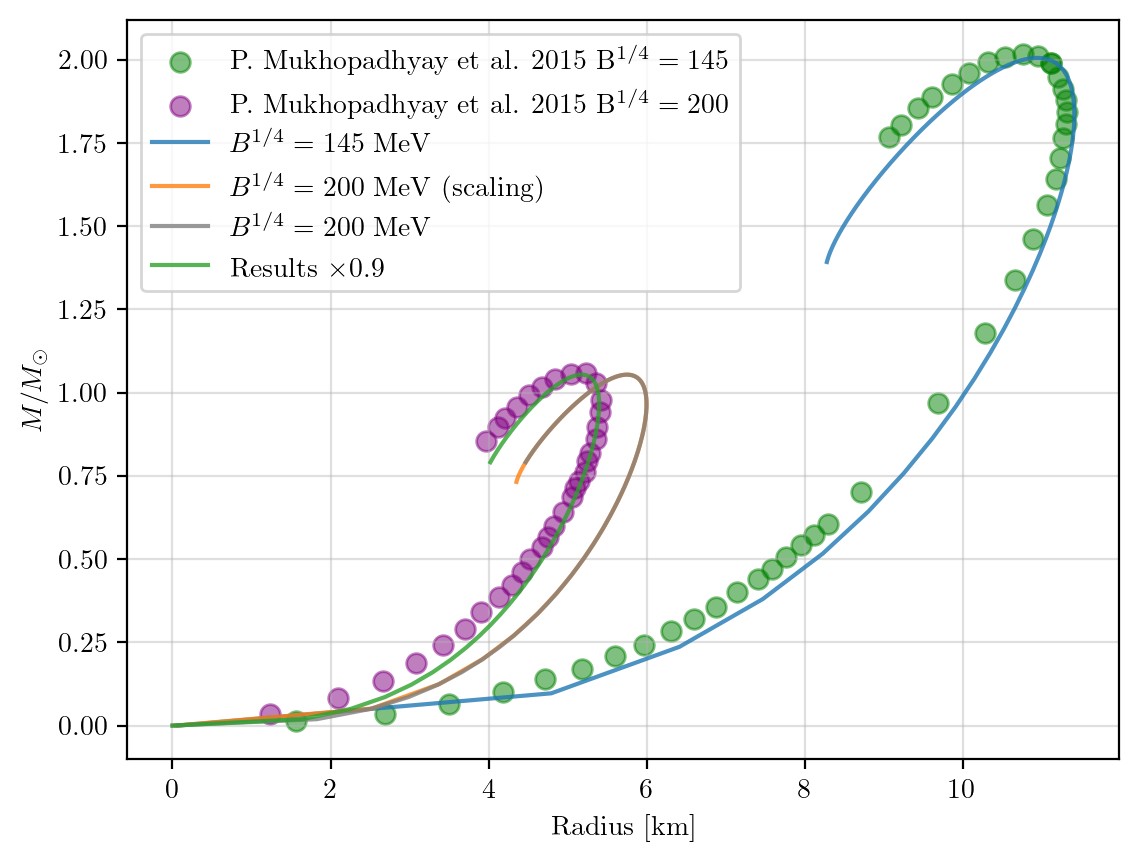

In [80]:
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

data = pd.read_csv('../Data/BagModel145.csv')
data= data[:-2]
data = data.drop(32)
data = data.drop(33)
plt.scatter(data['x'], data[' y'], label= 'P. Mukhopadhyay et al. 2015 B$^{1/4}=145$', s=50, alpha=0.5,color='green')
data = pd.read_csv('../Data/BagModel200.csv')

plt.scatter(data['x'], data[' y'], label='P. Mukhopadhyay et al. 2015 B$^{1/4}=200$', s=50, alpha=0.5,color='purple')

# --- Convert dimensionless R', M' ---
Radius_1 = np.array(list_R_1)
Mass_1 = np.array(list_M_1)


Rkm_1 = Radius_1 * M_p/ (2 * np.sqrt(B_1)) * hc * 1e-18 #km
Mass_mev_1 = Mass_1 * M_p**3 / (2 * np.sqrt(B_1)) #MeV


Mass_sol_1 = (Mass_mev_1 * mev_to_kg) / msun_kg

plt.plot(Rkm_1, Mass_sol_1, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)



# using scaling law:

list_R_2_scaling = (145/200)**2 * Radius_1
list_M_2_scaling = (145/200)**2 * Mass_1


Radius_2 = np.array(list_R_2_scaling)
Mass_2 = np.array(list_M_2_scaling)

Rkm_2 = Radius_2 * M_p/ (2 * np.sqrt(B_1)) * hc * 1e-18 #km
Mass_mev_2 = Mass_2 * M_p**3 / (2 * np.sqrt(B_1)) #MeV


Mass_sol_2 = (Mass_mev_2 * mev_to_kg) / msun_kg

plt.plot(Rkm_2, Mass_sol_2, label=r'$B^{1/4}=200\ \mathrm{MeV}$ (scaling)', alpha=0.8)





# Using found values
Radius_2 = np.array(list_R_2)
Mass_2 = np.array(list_M_2)

Rkm_2 = Radius_2 * M_p/ (2 * np.sqrt(B_2)) * hc * 1e-18 #km
Mass_mev_2 = Mass_2 * M_p**3 / (2 * np.sqrt(B_2)) #MeV


Mass_sol_2 = (Mass_mev_2 * mev_to_kg) / msun_kg

plt.plot(Rkm_2, Mass_sol_2, label=r'$B^{1/4}=200\ \mathrm{MeV}$', alpha=0.8, color = 'grey')


# try to recover the results

Radius_test_2 = Rkm_2 * 0.9
plt.plot(Radius_test_2, Mass_sol_2, label=r'Results $\times0.9$', alpha=0.8)


# --- Plot ---

plt.xlabel("Radius [km]")
plt.ylabel(r"$M/M_\odot$")
plt.grid()
plt.legend()
plt.show()


i want to see what happens if i define my eos closer to zero

In [68]:

list_e_1 = np.linspace(1+2e-16, 10, 2000) # already in units of 4B

list_p_1 = 1/3*(list_e_1 - 1)

#print maximums of e and p
max_e_1 = np.max(list_e_1)
max_p_1 = np.max(list_p_1)
print(f"Max energy density {max_e_1}")
print(f"Max pressure : {max_p_1}")

min_e_1 = np.min(list_e_1)
min_p_1 = np.min(list_p_1)
print(f"Min energy density: {min_e_1}")
print(f"Min pressure : {min_p_1}")



Max energy density 10.0
Max pressure : 3.0
Min energy density: 1.0000000000000002
Min pressure : 7.401486830834377e-17


In [69]:
list_e_1_adim = list_e_1
list_p_1_adim = list_p_1
def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_1_adim, list_e_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_1), 'MeV^4')

    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R = []
list_M = []





for i in range(len(list_e_1_adim)):

    e, p = list_e_1_adim[i], list_p_1_adim[i]

    r0 = 1e-5

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R.append(R_surface)
    list_M.append(M_surface)

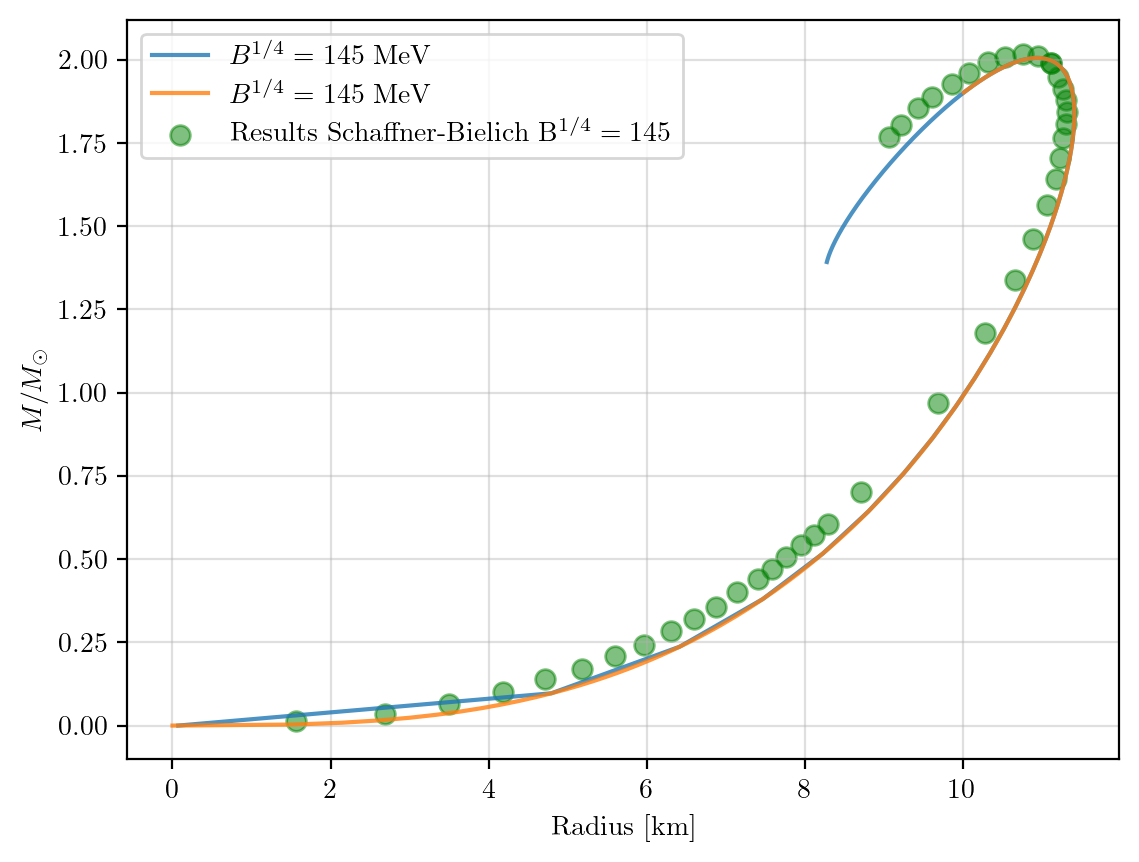

In [70]:
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30


# --- Convert dimensionless R', M' ---
Radius_1 = np.array(list_R_1)
Mass_1 = np.array(list_M_1)


Rkm_1 = Radius_1 * M_p/ (2 * np.sqrt(B_1)) * hc * 1e-18 #km
Mass_mev_1 = Mass_1 * M_p**3 / (2 * np.sqrt(B_1)) #MeV


Mass_sol_1 = (Mass_mev_1 * mev_to_kg) / msun_kg

plt.plot(Rkm_1, Mass_sol_1, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)




# --- Convert dimensionless R', M' ---
Radius = np.array(list_R)
Mass = np.array(list_M)


Rkm = Radius* M_p/ (2 * np.sqrt(B_1)) * hc * 1e-18 #km
Mass_mev = Mass * M_p**3 / (2 * np.sqrt(B_1)) #MeV


Mass_sol = (Mass_mev * mev_to_kg) / msun_kg

plt.plot(Rkm, Mass_sol, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('../Data/BagModel145.csv')
data= data[:-2]
data = data.drop(32)
data = data.drop(33)
plt.scatter(data['x'], data[' y'], label='Results  Schaffner-Bielich B$^{1/4}=145$', s=50, alpha=0.5,color='green')



# --- Plot ---

plt.xlabel("Radius [km]")
plt.ylabel(r"$M/M_\odot$")
plt.grid()
plt.legend()
plt.show()


Max energy density 10.0
Max pressure : 3.0
Min energy density: 1.0000000000000002
Min pressure : 7.401486830834377e-17


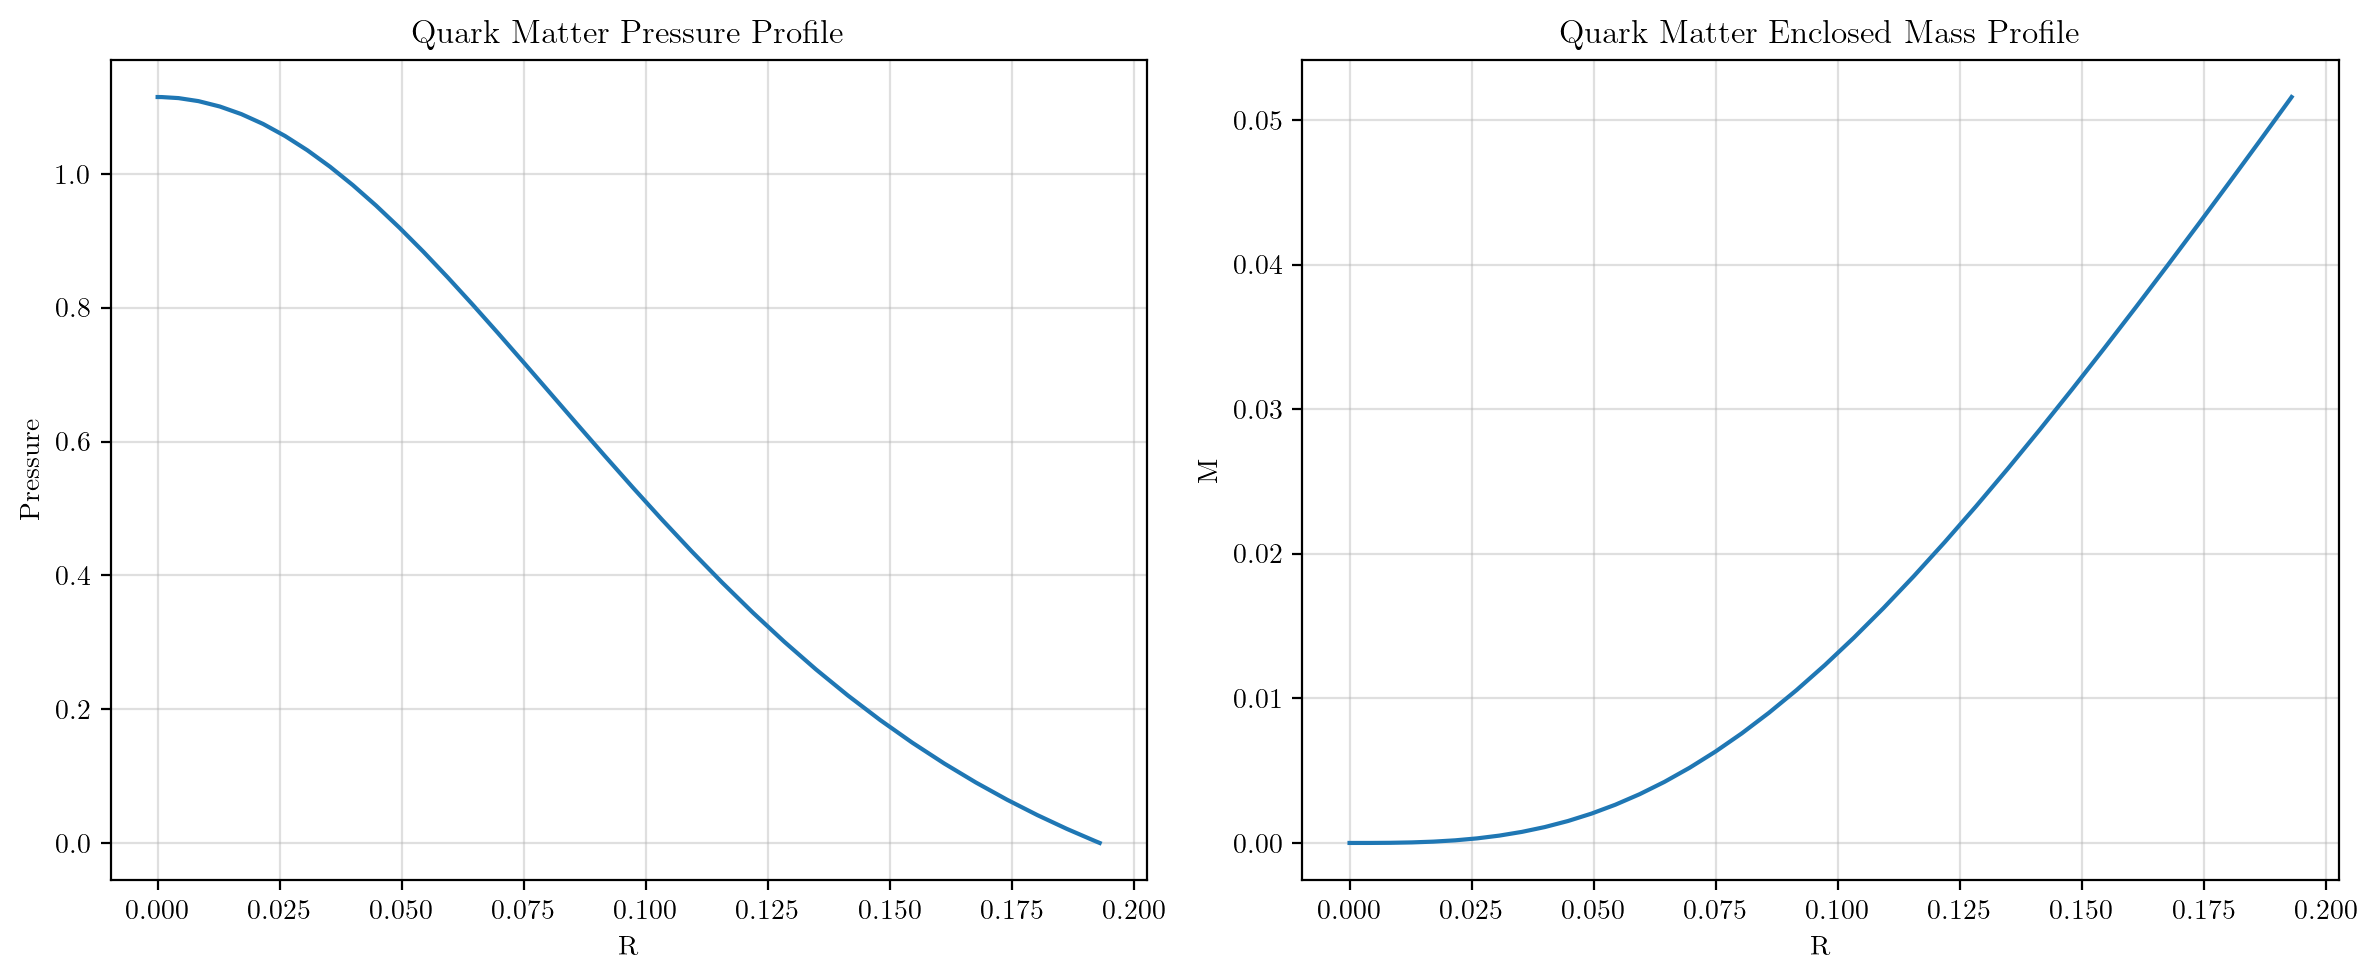

Final Pressure Quark Matter: 1.8650655456074566e-08 MeV^4


In [71]:

list_e_1 = np.linspace(1+2e-16, 10, 2000) # already in units of 4B

list_p_1 = 1/3*(list_e_1 - 1)

#print maximums of e and p
max_e_1 = np.max(list_e_1)
max_p_1 = np.max(list_p_1)
print(f"Max energy density {max_e_1}")
print(f"Max pressure : {max_p_1}")

min_e_1 = np.min(list_e_1)
min_p_1 = np.min(list_p_1)
print(f"Min energy density: {min_e_1}")
print(f"Min pressure : {min_p_1}")

list_e_1_adim = list_e_1
list_p_1_adim = list_p_1

def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_1_adim, list_e_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 1e10),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_1), 'MeV^4')
    P_profile = sol.y[0]
    M_profile = sol.y[1]
    R_profile = sol.t

    
    return R_surface, M_surface, P_profile, M_profile, R_profile


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

# Initial conditions
r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B_1) #1000 mev /fm^ 3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, list_e_1_adim, list_p_1_adim)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark
x0_quark = [central_pressure_quark, central_mass_quark]

R_surface, M_surface, P_profile, M_profile, R_profile = solve_TOV(central_energy_quark, x0_quark)


# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))
plt.plot(R_profile, P_profile)
plt.xlabel("R")
plt.ylabel("Pressure")
plt.title(" Quark Matter Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(R_profile,M_profile)
plt.xlabel("R")
plt.ylabel("M")
plt.title("Quark Matter Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

# final pressure
print(f"Final Pressure Quark Matter: {P_profile[-1] * (4 * B_1)} MeV^4")

In [72]:
#final mass and radius
R_km = R_surface * M_p.value/ (2 * np.sqrt(B_1)) * hc * 1e-18 #km
Mass_mev = M_surface * M_p.value**3 / (2 * np.sqrt(B_1)) #MeV
Mass_sol = (Mass_mev * mev_to_kg) / msun_kg
print(f"Final Radius Quark Matter: {R_km} km")
print(f"Final Mass Quark Matter: {Mass_sol} M_sun")


Final Radius Quark Matter: 11.053038047658402 km
Final Mass Quark Matter: 2.002096893008893 M_sun
